# EoS model finder

I will be finding numerical tables of pressures and energy densities using formulae from stat mech.
Then I will fit the tables with an EoS model.
Using natural units

### Variables:

epsilon = energy density

chem_potential = chemical potential

num_density = number density

k_F = Fermi momentum

rho = mass density

### Constants:

g = # of spin states per energy state

m_N = mass of neutron

In [1]:
from scipy.integrate import quad
import numpy as np
from numpy import pi, polyfit
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
natural_units = [(u.MeV, u.fm ** (-1), lambda fm: 1 / 197 * fm, lambda MeV: 197 * MeV)]

## Non-interacting pure neutron Fermi gas model

In [3]:
g = 2
m_N = 939.565 * u.MeV

In [4]:
# Fermi momentum
def find_k_F(rho):
    result = (3 * pi ** 2 * rho / m_N) ** (1 / 3)
    return result

# Energy density epsilon
def find_epsilon(rho):
    k_F = find_k_F(rho).value
    integrand = lambda k: 1 / (2 * pi ** 2) * k ** 2 * np.sqrt(k ** 2 + m_N.value ** 2)
    integral, _ = quad(integrand, 0, k_F)
    result = g * integral * u.MeV / u.fm ** 3
    return result

# Number density
def find_num_density(rho):
    k_F = find_k_F(rho).value
    integrand = lambda k: 1 / (2 * pi ** 2) * k ** 2
    integral, _ = quad(integrand, 0, k_F)
    result = g * integral / u.fm ** 3
    return result

def num_density_test(rho):
    k_F = find_k_F(rho).value
    result = k_F ** 3 / (3 * pi ** 2)
    return result

# Chemical potential
def find_chem_potential(rho):
    k_F = find_k_F(rho)
    result = np.sqrt(k_F.to(u.MeV, equivalencies = natural_units) ** 2 + m_N ** 2)
    return result

# Pressure
def find_pressure(rho):
    k_F = find_k_F(rho)
    epsilon = find_epsilon(rho)
    num_density = find_num_density(rho)
    chem_potential = find_chem_potential(rho)
    result = - epsilon + chem_potential * num_density
    return result

### Set range of mass densities

In [5]:
# Nuclear saturation number density is 0.16 fm^(-3)
rho = np.logspace(-2, 7, num = 10000) * u.MeV / u.fm ** 3

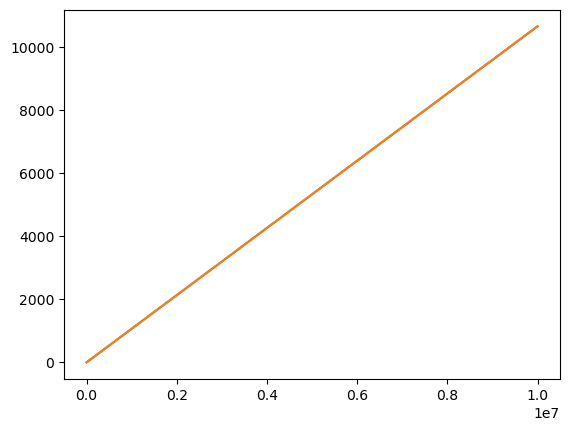

In [6]:
num1 = [find_num_density(i).value for i in rho]
num2 = [num_density_test(i) for i in rho]
plt.plot(rho, num1)
plt.plot(rho, np.array(num2))

In [7]:
rho

<Quantity [1.00000000e-02, 1.00207468e-02, 1.00415367e-02, ...,
           9.95863511e+06, 9.97929612e+06, 1.00000000e+07] MeV / fm3>

### Find arrays of pressure and energy density

In [8]:
epsilon = []
pressure = []
for mass_density in rho:
    epsilon.append(find_epsilon(mass_density).value)
    pressure.append(find_pressure(mass_density).value)

In [9]:
# print(epsilon, pressure)

### Plotting EoS

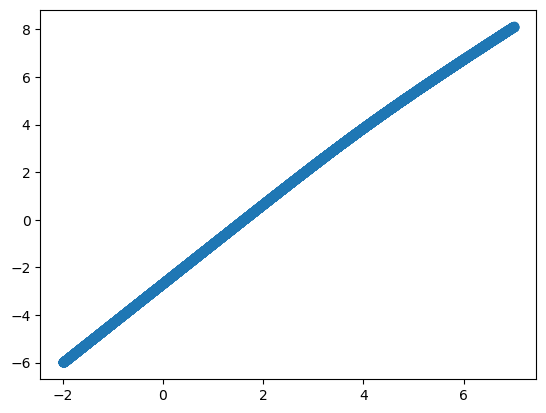

In [10]:
plt.plot(np.log10(epsilon), np.log10(pressure), "o");

### Fitting EoS

In [11]:
def EoS_model_attempt_1(epsilon, K, gamma):
    result = K * epsilon ** gamma
    return result

Guesses for K and gamma:

In [12]:
K_guess = 0.07
gamma_guess = 1.4
init_guesses = (K_guess, gamma_guess)

In [13]:
fitpars, error = curve_fit(EoS_model_attempt_1,
                           epsilon, pressure,
                           p0 = init_guesses)

print(f"fit parameters: {fitpars}, error in fit parameters: {error}.")

fit parameters: [0.03853229 1.36253787], error in fit parameters: [[ 6.82322446e-10 -1.12343279e-09]
 [-1.12343279e-09  1.85071770e-09]].


In [14]:
model_pressure = EoS_model_attempt_1(epsilon, *fitpars)

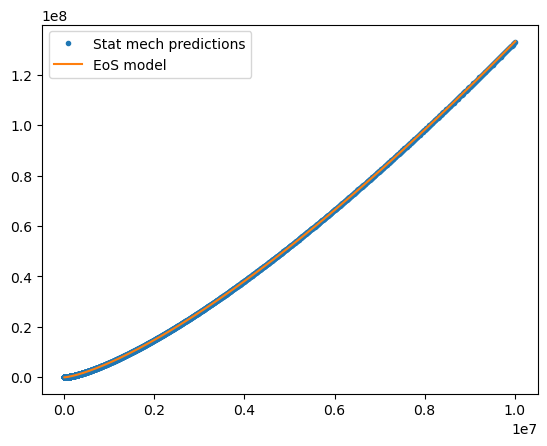

In [15]:
plt.plot(epsilon,
         pressure,
         "o",
         markersize = 3,
         label = "Stat mech predictions",
        );

plt.plot(epsilon,
         model_pressure,
         label = "EoS model"
        );

plt.legend();

Plotting residuals

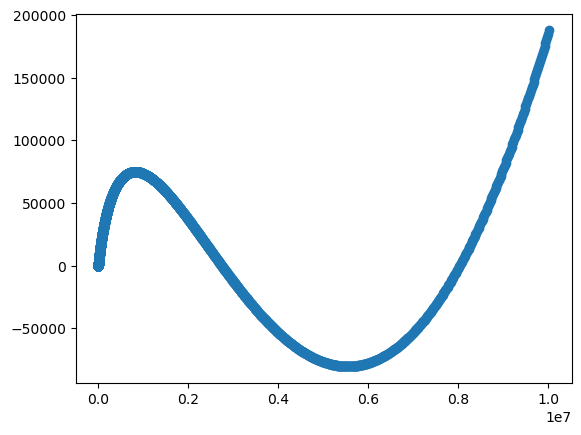

In [16]:
residuals = model_pressure - pressure

plt.plot(epsilon, residuals, "o");

Maximum % error is 98.60 %. Minimum good energy density is 289008.38 in natural units, 4.63e+38 cgs.


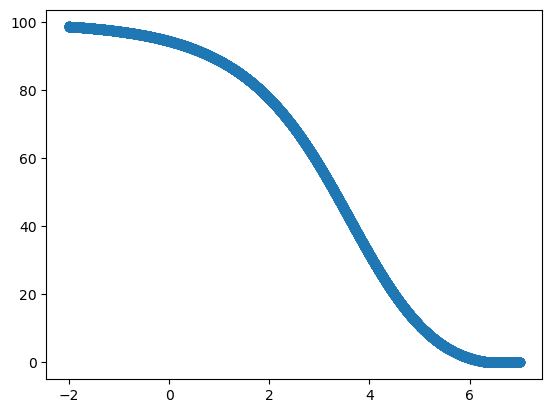

In [17]:
# Finding maximum residual
perc_error = (np.abs(residuals) / model_pressure * 100)
epsilon_5_perc_err = epsilon[np.where((perc_error > 5.0) & (perc_error < 5.1))[0][0]]
plt.plot(np.log10(epsilon), perc_error, "o");
perc_error = perc_error[~np.isnan(perc_error)]
max_perc_error = np.max(perc_error)
print(f"Maximum % error is {max_perc_error:.2f} %. Minimum good energy density is {epsilon_5_perc_err:.2f} in natural units, {(epsilon_5_perc_err * u.MeV / u.fm ** 3).to(u.Ba).value:.2e} cgs.")

### Fitting the residuals - polynomial attempt

In [18]:
# def residuals_model_attempt_1(epsilon, coeff_a, coeff_b, coeff_c, exp_a, exp_b, exp_c):
#     result = coeff_a * epsilon ** exp_a + coeff_b * epsilon ** exp_b
#     return result

Guesses for residuals_model:

In [19]:
# coeff_a_guess = 3 * 10 ** (-11)
# coeff_b_guess = 3 * 10 ** (-2)
# coeff_c_guess = 5 * 10 ** (-1)
# exp_a_guess = 3
# exp_b_guess = 4.4 * 10 ** (-1)
# exp_c_guess = 4.4 * 10 ** (-1)
# init_guesses = (coeff_a_guess, coeff_b_guess, coeff_c_guess, exp_a_guess, exp_b_guess, exp_c_guess)

In [20]:
# fitpars, error = curve_fit(residuals_model_attempt_1,
#                            epsilon, residuals,
#                            p0 = init_guesses)

# print(f"fit parameters: {fitpars}, error in fit parameters: {error}.")

In [21]:
# model_residuals = residuals_model_attempt_1(epsilon, *fitpars)

In [22]:
# plt.plot(epsilon,
#          residuals,
#          "o",
#          markersize = 3,
#          label = "Residuals",
#         );

# plt.plot(epsilon,
#          model_residuals,
#          label = "Residuals model"
#         );

# plt.legend();

It seems that the residual model is not a polytrope; maybe it will work better if I make another attempt at fitting the EoS directly.

### Fitting EoS attempt 2

In [23]:
# def EoS_model_attempt_2(epsilon, K_1, K_2, gamma_1, gamma_2):
#     result = K_1 * epsilon ** gamma_1 + K_2 * epsilon ** gamma_2
#     return result

Guesses for EoS 2 parameters

In [24]:
# K_1_guess = 0.026
# K_2_guess = 1
# gamma_1_guess = 1.6
# gamma_2_guess = 1
# init_guesses = (K_1_guess, K_2_guess, gamma_1_guess, gamma_2_guess)

In [25]:
# fitpars, error = curve_fit(EoS_model_attempt_2,
#                            epsilon, pressure,
#                            p0 = init_guesses)

# print(f"fit parameters: {fitpars}, error in fit parameters: {error}.")

In [26]:
# model_pressure = EoS_model_attempt_2(epsilon, *fitpars)

In [27]:
# plt.plot(epsilon,
#          pressure,
#          "o",
#          markersize = 3,
#          label = "Stat mech predictions",
#         );

# plt.plot(epsilon,
#          model_pressure,
#          label = "EoS model"
#         );

# plt.legend();

Plotting residuals

In [28]:
# residuals = model_pressure - pressure

# plt.plot(epsilon, residuals, "o");

Weird - maybe the residuals are actually a sinusoid rather than a polynomial.

### Fitting residuals - poytrope model

In [29]:
# def residuals_model_attempt_2(epsilon, amplitude, coefficient):
#     epsilon = np.asarray(epsilon)
#     result = amplitude * np.sin(coefficient * epsilon)
#     return result

Guesses for residuals model attempt 2

In [30]:
# amplitude_guess = 150
# coefficient_guess = 1 / 10000
# init_guesses = (amplitude_guess, coefficient_guess)

In [31]:
# fitpars, error = curve_fit(residuals_model_attempt_2,
#                            epsilon, residuals,
#                            p0 = init_guesses)

# print(f"fit parameters: {fitpars}, error in fit parameters: {error}.")

In [32]:
# model_residuals = residuals_model_attempt_2(epsilon, *fitpars)

In [33]:
# plt.plot(epsilon,
#          residuals,
#          "o",
#          markersize = 3,
#          label = "Residuals",
#         );

# plt.plot(epsilon,
#          model_residuals,
#          label = "Residuals model"
#         );

# plt.legend();

It's closer than the polynomial fit, but I don't think the residuals are a simple sinusoid, because the amplitude is off. Potentially it could be a sum of two sinusoids.

### Fitting residuals with a sum of two sinusoids

In [34]:
# def residuals_model_attempt_3(epsilon, amplitude_1, amplitude_2, coefficient_1, coefficient_2):
#     epsilon = np.asarray(epsilon)
#     result = amplitude_1 * np.sin(coefficient_1 * epsilon) + amplitude_2 * np.sin(coefficient_2 * epsilon)
#     return result

Guesses for residuals model attempt 3

In [35]:
# amplitude_1_guess = 200
# amplitude_2_guess = 200
# coefficient_1_guess = 1 / 5000
# coefficient_2_guess = 1 / 5000
# init_guesses = (amplitude_1_guess, amplitude_2_guess, coefficient_1_guess, coefficient_2_guess)

In [36]:
# fitpars, error = curve_fit(residuals_model_attempt_3,
#                            epsilon, residuals,
#                            p0 = init_guesses)

# print(f"fit parameters: {fitpars}, error in fit parameters: {error}.")

In [37]:
# model_residuals = residuals_model_attempt_3(epsilon, *fitpars)

In [38]:
# plt.plot(epsilon,
#          residuals,
#          "o",
#          markersize = 3,
#          label = "Residuals",
#         );

# plt.plot(epsilon,
#          model_residuals,
#          label = "Residuals model"
#         );

# plt.legend();

I don't think this is a sum of sinusoids, because the far right doesn't look like a peak, and it should be. It looks more similar to a sum of polytropes, but I can't do this on my own. I will try normalizing the residuals and trying attempt 1 again.

### Normalizing residuals

In [39]:
# def normalize_data(data_array):
#     result = (data_array - data_array.min()) / (data_array.max() - data_array.min())
#     return result

In [40]:
# normalized_residuals = normalize_data(residuals)
# normalized_epsilon = normalize_data(np.asarray(epsilon))

Fitting normalized residuals

In [41]:
# coeff_a_guess = 1
# coeff_b_guess = 1
# coeff_c_guess = 1
# exp_a_guess = 3
# exp_b_guess = 2
# exp_c_guess = 1
# init_guesses = (coeff_a_guess, coeff_b_guess, coeff_c_guess, exp_a_guess, exp_b_guess, exp_c_guess)

In [42]:
# fitpars, error = curve_fit(residuals_model_attempt_1,
#                            normalized_epsilon, normalized_residuals,
#                            p0 = init_guesses)

# print(f"fit parameters: {fitpars}, error in fit parameters: {error}.")

In [43]:
# model_residuals = residuals_model_attempt_1(normalized_epsilon, *fitpars)

In [44]:
# plt.plot(normalized_epsilon,
#          normalized_residuals,
#          "o",
#          markersize = 3,
#          label = "Residuals",
#         );

# plt.plot(normalized_epsilon,
#          model_residuals,
#          label = "Residuals model"
#         );

# plt.legend();

### Trying without initial guess

In [45]:
# fitpars, error = curve_fit(residuals_model_attempt_1,
#                            normalized_epsilon, normalized_residuals,
#                           )

# print(f"fit parameters: {fitpars}, error in fit parameters: {error}.")

In [46]:
# model_residuals = residuals_model_attempt_1(normalized_epsilon, *fitpars)

In [47]:
# plt.plot(normalized_epsilon,
#          normalized_residuals,
#          "o",
#          markersize = 3,
#          label = "Residuals",
#         );

# plt.plot(normalized_epsilon,
#          model_residuals,
#          label = "Residuals model"
#         );

# plt.legend();

### Using polyfit

In [48]:
fitpars = polyfit(epsilon,
                  residuals,
                  15
                 )

print(f"fit parameters: {fitpars}")

fit parameters: [ 2.78812369e-94 -2.11684525e-86  7.25283793e-79 -1.48237230e-71
  2.01294678e-64 -1.91447901e-57  1.31003838e-50 -6.52397380e-44
  2.36544849e-37 -6.18933410e-31  1.14865321e-24 -1.47635557e-18
  1.28917902e-12 -7.89011655e-07  3.37650217e-01  2.41328763e+01]


In [49]:
def residuals_poly_model(epsilon, coeff_a, coeff_b, coeff_c, coeff_d, coeff_e, coeff_f, coeff_g, coeff_h, coeff_i, coeff_j, coeff_k, coeff_l, coeff_m, coeff_n, coeff_o, constant):
    epsilon = np.asarray(epsilon)
    result = coeff_a * epsilon ** 15 + coeff_b * epsilon ** 14 + coeff_c * epsilon ** 13 + coeff_d * epsilon ** 12 + coeff_e * epsilon ** 11 + coeff_f * epsilon ** 10 + coeff_g * epsilon ** 9 + coeff_h * epsilon ** 8 + coeff_i * epsilon ** 7 + coeff_j * epsilon ** 6 + coeff_k * epsilon ** 5 + coeff_l * epsilon ** 4 + coeff_m * epsilon ** 3 + coeff_n * epsilon ** 2 + coeff_o * epsilon
    return result

In [50]:
model_residuals = residuals_poly_model(epsilon, *fitpars)

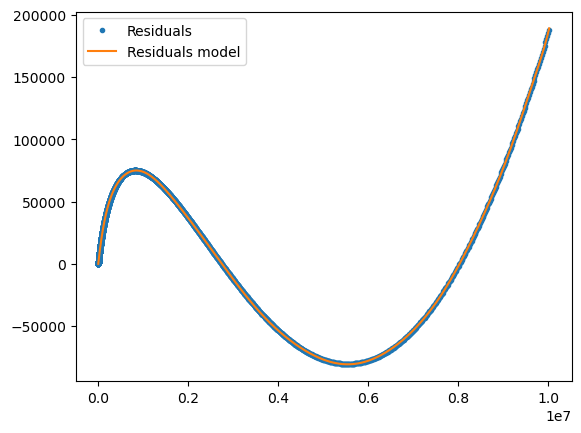

In [51]:
plt.plot(epsilon,
         residuals,
         "o",
         markersize = 3,
         label = "Residuals",
        );

plt.plot(epsilon,
         model_residuals,
         label = "Residuals model"
        );

plt.legend();

Plotting residuals of residuals

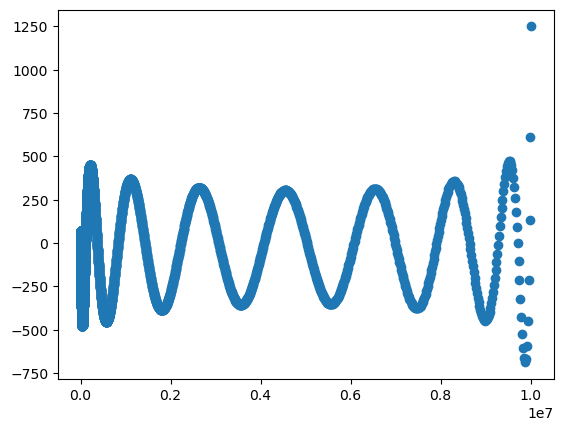

In [52]:
residual_residuals = model_residuals - residuals

plt.plot(epsilon, residual_residuals, "o");

This is an acceptable amount of error now, because 0.5 / 4000 is about 0.01 % error.

Maximum % error is 4554.24 %. Minimum good energy density is 2078.42 in natural units, 3.33e+36 cgs.


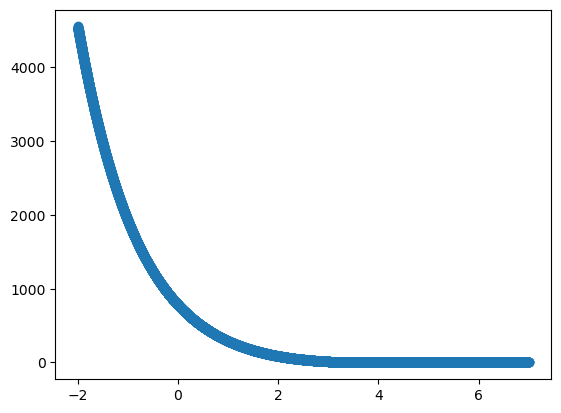

In [53]:
# Finding maximum residual
perc_error = (np.abs(residual_residuals) / model_pressure * 100)
epsilon_5_perc_err = epsilon[np.where(perc_error < 5.0)[0][0]]
plt.plot(np.log10(epsilon), perc_error, "o");
perc_error = perc_error[~np.isnan(perc_error)]
max_perc_error = np.max(perc_error)
print(f"Maximum % error is {max_perc_error:.2f} %. Minimum good energy density is {epsilon_5_perc_err:.2f} in natural units, {(epsilon_5_perc_err * u.MeV / u.fm ** 3).to(u.Ba).value:.2e} cgs.")